In [1]:
import os
os.environ['JAVA_HOME'] = 'C:\Program Files\Java\jdk-11'

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Project").getOrCreate()

In [3]:
data = spark.read.csv("bank_transactions.csv",inferSchema=True, header=True)
data.show(5)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|           T1|  C5841053|    10/1/94|         F|  JAMSHEDPUR|          17819.05|         2/8/16|         143207|                   25.0|
|           T2|  C2142763|     4/4/57|         M|     JHAJJAR|           2270.69|         2/8/16|         141858|                27999.0|
|           T3|  C4417068|   26/11/96|         F|      MUMBAI|          17874.44|         2/8/16|         142712|                  459.0|
|           T4|  C5342380|    14/9/73|         F|      MUMBAI|         866503.21|         2/8/16|         142714|                 2060.0|
|           T5|  C9031234|    24/3

In [4]:
print(f'Number of rows and column in dataframe: {data.toPandas().shape}')

Number of rows and column in dataframe: (1048567, 9)


In [5]:
data.printSchema()

root
 |-- TransactionID: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: string (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: double (nullable = true)
 |-- TransactionDate: string (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount (INR): double (nullable = true)



In [6]:
from pyspark.sql import functions as F

In [7]:
for col in data.columns:
    null_count = data.filter(data[col].isNull()).count()
    print(f"Column '{col}' has {null_count} null values")

Column 'TransactionID' has 0 null values
Column 'CustomerID' has 0 null values
Column 'CustomerDOB' has 0 null values
Column 'CustGender' has 1100 null values
Column 'CustLocation' has 151 null values
Column 'CustAccountBalance' has 2369 null values
Column 'TransactionDate' has 0 null values
Column 'TransactionTime' has 0 null values
Column 'TransactionAmount (INR)' has 0 null values


In [8]:
data_filled = data.fillna({
    'CustGender': 'Unknown',
    'CustLocation': 'Unknown',
    'CustAccountBalance': 0
})
for col in data_filled.columns:
    null_count = data_filled.filter(data_filled[col].isNull()).count()
    print(f"Column '{col}' has {null_count} null values")

Column 'TransactionID' has 0 null values
Column 'CustomerID' has 0 null values
Column 'CustomerDOB' has 0 null values
Column 'CustGender' has 0 null values
Column 'CustLocation' has 0 null values
Column 'CustAccountBalance' has 0 null values
Column 'TransactionDate' has 0 null values
Column 'TransactionTime' has 0 null values
Column 'TransactionAmount (INR)' has 0 null values


In [9]:
duplicates = data_filled.groupBy(['CustomerID']).count().filter(F.col("count") > 1)
duplicates.show()
print(f'Number of rows and column in dataframe: {data.toPandas().shape}')

+----------+-----+
|CustomerID|count|
+----------+-----+
|  C6421261|    2|
|  C2939112|    2|
|  C7817677|    4|
|  C5638051|    3|
|  C7623541|    3|
|  C4338344|    3|
|  C4927991|    2|
|  C4528281|    2|
|  C2618978|    2|
|  C2418945|    2|
|  C2827378|    2|
|  C3023473|    2|
|  C7410477|    2|
|  C3624341|    2|
|  C2315130|    2|
|  C3229976|    2|
|  C1321446|    2|
|  C5112381|    4|
|  C1636852|    2|
|  C3931118|    2|
+----------+-----+
only showing top 20 rows

Number of rows and column in dataframe: (1048567, 9)


In [10]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [11]:
# Index categorical columns 
indexer_gender = StringIndexer(inputCol="CustGender", outputCol="CustGenderIndexed", handleInvalid="skip")
indexer_location = StringIndexer(inputCol="CustLocation", outputCol="CustLocationIndexed", handleInvalid="skip")

# Fit and transform the data
data_indexed = indexer_gender.fit(data_filled).transform(data_filled)
data_indexed = indexer_location.fit(data_indexed).transform(data_indexed)

# Assemble features for KMeans
feature_columns = ["CustAccountBalance", "TransactionAmount (INR)", "CustGenderIndexed", "CustLocationIndexed"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_features = assembler.transform(data_indexed)

In [12]:
from pyspark.ml.feature import StandardScaler

In [13]:
# Normalize the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
data_scaled = scaler.fit(data_features).transform(data_features)

In [14]:
from pyspark.ml.clustering import KMeans

In [15]:
kmeans = KMeans(featuresCol="scaledFeatures", k=5)
model = kmeans.fit(data_scaled)

# Make predictions (assign cluster labels)
predictions = model.transform(data_scaled)
predictions.show()

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+-----------------+-------------------+--------------------+--------------------+----------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|CustGenderIndexed|CustLocationIndexed|            features|      scaledFeatures|prediction|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+-----------------+-------------------+--------------------+--------------------+----------+
|           T1|  C5841053|    10/1/94|         F|  JAMSHEDPUR|          17819.05|         2/8/16|         143207|                   25.0|              1.0|               62.0|[17819.05,25.0,1....|[-0.1151016257135...|         0|
|           T2|  C2142763|     4/4/57|         M|     JHAJJAR|           2270.69|   

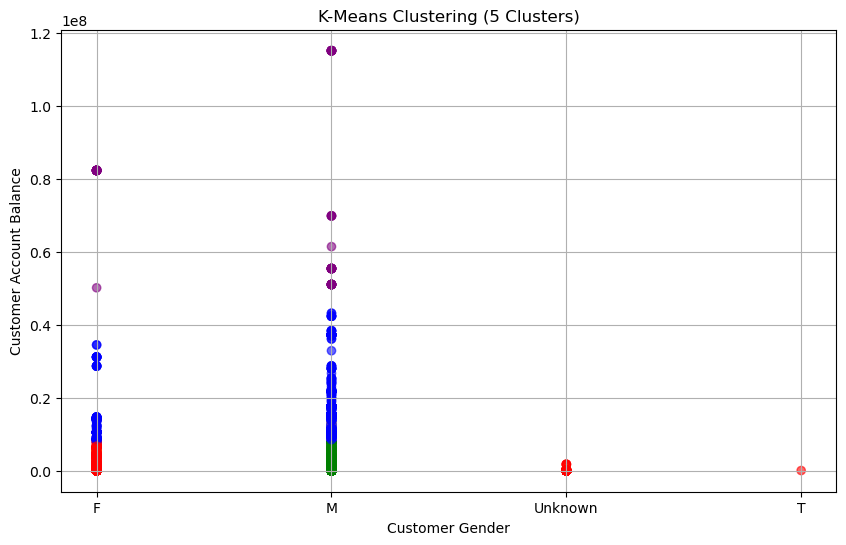

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

predictions_pd = predictions.select("CustGender", "CustAccountBalance", "prediction").toPandas()

colors = ['red', 'green', 'blue', 'orange', 'purple']
cluster_colors = predictions_pd['prediction'].map({0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'purple'})

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['CustGender'], 
            predictions_pd['CustAccountBalance'], 
            c=cluster_colors, 
            alpha=0.6)

plt.title('K-Means Clustering (5 Clusters)')
plt.xlabel('Customer Gender')
plt.ylabel('Customer Account Balance')

plt.grid()
plt.show()

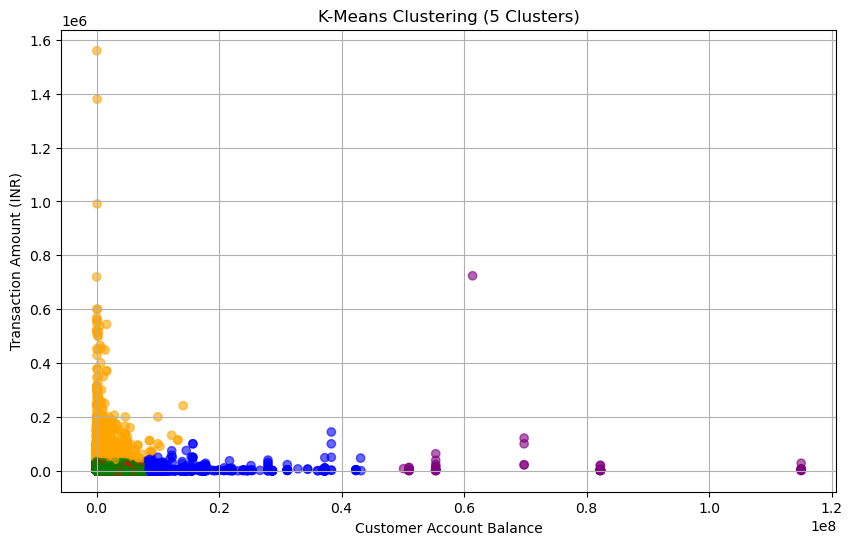

In [17]:
predictions_pd = predictions.select("CustAccountBalance", "TransactionAmount (INR)", "prediction").toPandas()

colors = ['red', 'green', 'blue', 'orange', 'purple']
cluster_colors = predictions_pd['prediction'].map({0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'purple'})

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['CustAccountBalance'], 
            predictions_pd['TransactionAmount (INR)'], 
            c=cluster_colors, 
            alpha=0.6)

plt.title('K-Means Clustering (5 Clusters)')
plt.xlabel('Customer Account Balance')
plt.ylabel('Transaction Amount (INR)')

plt.grid()
plt.show()

In [18]:
transaction_count_df = predictions.groupBy("CustomerID").agg(
    F.count("TransactionID").alias("TransactionCount")
)

data_with_transactions = predictions.join(transaction_count_df, on="CustomerID", how="left")

cluster_stats = data_with_transactions.groupBy("prediction").agg(
    F.count("CustomerID").alias("CustomerCount"),
    F.avg("CustAccountBalance").alias("AvgAccountBalance"),
    F.avg("TransactionAmount (INR)").alias("AvgTransactionAmount"),
    F.avg("TransactionCount").alias("AvgTransactionCount")
)

gender_counts = data_with_transactions.groupBy("prediction", "CustGender").agg(
    F.count("CustomerID").alias("GenderCount")
)

gender_pivot = gender_counts.groupBy("prediction").pivot("CustGender").agg(
    F.sum("GenderCount").alias("GenderCount")
)
final_stats = cluster_stats.join(gender_pivot, on="prediction", how="left")

final_stats_sorted = final_stats.orderBy("prediction")
final_stats_sorted.show(truncate=False)

+----------+-------------+--------------------+--------------------+-------------------+------+------+----+-------+
|prediction|CustomerCount|AvgAccountBalance   |AvgTransactionAmount|AvgTransactionCount|F     |M     |T   |Unknown|
+----------+-------------+--------------------+--------------------+-------------------+------+------+----+-------+
|0         |281804       |94477.2957182299    |1407.7268520673942  |1.3565598784971116 |280711|NULL  |1   |1092   |
|1         |761557       |97901.42334723505   |1233.7966725931321  |1.3572903932338616 |NULL  |761557|NULL|NULL   |
|2         |853          |1.5564438078124275E7|5432.792016412661   |1.3388042203985933 |170   |683   |NULL|NULL   |
|3         |4293         |429948.90549499186  |71859.7760423946    |1.3605870020964361 |1035  |3250  |NULL|8      |
|4         |60           |7.385203941966668E7 |22633.183666666664  |1.4                |20    |40    |NULL|NULL   |
+----------+-------------+--------------------+--------------------+----

# Cluster Analysis


## Cluster 0:
- **Customer Count**: **High** (281,740 customers)
  - Represents a large and diverse customer base, suitable for mass marketing.
- **Average Account Balance**: **Low** (₹100,300)
  - Customers in this cluster tend to have lower account balances, suggesting they may be more cost-sensitive.
- **Average Transaction Amount**: **Low** (₹1,383)
  - This indicates a focus on smaller, everyday transactions rather than significant purchases.
- **Average Transaction Count**: **Low** (1.36 transactions)
  - Indicates limited transaction activity among these customers.
- **Gender Distribution**: 
  - **Very High representation** of Females (280,647), with **1 Male** and **1,092 Unknowns**.

---

## Cluster 1:
- **Customer Count**: **High** (761,554 customers)
  - This indicates a large customer base, which could be targeted for mass marketing.
- **Average Account Balance**: **Moderate** (₹105,937)
  - Customers in this cluster have a reasonable account balance, suggesting potential for upselling or cross-selling financial products.
- **Average Transaction Amount**: **Low** (₹1,213)
  - The low transaction amount suggests that these customers may be making smaller, more frequent transactions.
- **Average Transaction Count**: **Low** (1.36 transactions)
  - This indicates that while they are numerous, each customer is not transacting often.
- **Gender Distribution**: 
  - Predominantly **Male** (761,554 males), with no females or transgenders reported.
  
---

## Cluster 2:
- **Customer Count**: **Very Low** (221 customers)
  - Represents a niche market segment that may require tailored financial products.
- **Average Account Balance**: **Very High** (₹42,422,714)
  - These customers possess extraordinarily high balances, likely requiring specialized management.
- **Average Transaction Amount**: **Moderate** (₹7,238)
  - While their account balances are high, the transaction amounts are moderate.
- **Average Transaction Count**: **Low** (1.41 transactions)
  - The frequency of transactions remains low.
- **Gender Distribution**: 
  - **Low representation** of Females (37) and a **High representation** of Males (184).

---


## Cluster 3:
- **Customer Count**: **Low** (5,015 customers)
  - Indicates a niche market segment that could be valuable for personalized services.
- **Average Account Balance**: **High** (₹476,576)
  - Customers here have significant account balances, making them prime candidates for premium offerings.
- **Average Transaction Amount**: **High** (₹62,999)
  - The high transaction amount suggests these customers engage in larger financial activities.
- **Average Transaction Count**: **Low** (1.36 transactions)
  - Despite their high transaction values, the frequency remains low.
- **Gender Distribution**: 
  - Diverse representation: **1,243 Females**, **3,764 Males**, and **8 Unknowns**.

---

## Cluster 4:
- **Customer Count**: **Very Low** (37 customers)
  - Represents a highly exclusive segment that may require specialized services.
- **Average Account Balance**: **Very High** (₹1,997,579)
  - Extremely wealthy customers, indicating potential for wealth management services.
- **Average Transaction Amount**: **Very High** (₹537,129)
  - High transaction values further emphasize the wealth and spending capability of this group.
- **Average Transaction Count**: **Low** (1.24 transactions)
  - The low frequency suggests they may make significant purchases infrequently.
- **Gender Distribution**: 
  - **Low representation** of Females (9) and a **Moderate representation** of Males (28).

---

## Summary of Attributes
- **Customer Count**:
  - **High**: Cluster 1, Cluster 0
  - **Moderate**: Cluster 3
  - **Low**: Cluster 2
  - **Very Low**: Cluster 4

- **Average Account Balance**:
  - **Very High**: Cluster 4, Cluster 2
  - **High**: Cluster 3
  - **Moderate**: Cluster 1
  - **Low**: Cluster 0

- **Average Transaction Amount**:
  - **Very High**: Cluster 4
  - **High**: Cluster 3
  - **Moderate**: Cluster 2
  - **Low**: Cluster 1, Cluster 0

- **Average Transaction Count**:
  - **Low**: Cluster 1, Cluster 3, Cluster 4, Cluster 0
  - **Moderate**: Cluster 2

- **Gender Distribution**:
  - **Very High representation**: Cluster 0 (Females)
  - **High representation**: Cluster 2 (Males)
  - **Moderate representation**: Cluster 3 (Males)
  - **Low representation**: Cluster 4 (Females, Males)
